In [ ]:
import pickle
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
from google.colab import drive
import random
import torch.nn.functional as F
drive.mount('/content/drive')

class CustomDataset(Dataset):
  def __init__(self, xs, ys):
    self.x_data = xs
    self.y_data = ys


  def __len__(self):
    return len(self.x_data)


  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx])
    y = torch.FloatTensor([self.y_data[idx]])
    return x, y


filename = '/content/drive/My Drive/Colab Notebooks/NLP_Project/data.pkl'
infile = open(filename,'rb')
signal_data = pickle.load(infile)
infile.close()

def get_datas(test_person_idx=4, batch_size=64):
  val_idx_1 = 7
  val_idx_2 = 8
  if test_person_idx in [val_idx_1, val_idx_2]:
    if test_person_idx == val_idx_1:
      val_idx_1 = 4
    else:
      val_idx_2 = 4
  all_shape = 0
  train_list = [i for i in range(15) if i not in [test_person_idx, 7, 8]]
  people = list(signal_data.keys())
  val_list = [7,8]
  print('test data:', people[test_person_idx])
  for train_person_idx in train_list:
    person = people[train_person_idx]
    all_shape += signal_data[person]['x'].shape[0]
  train_Xs = np.empty((all_shape,512))
  train_ys = np.empty((all_shape,))

  accum_idx = 0
  for train_person_idx in train_list:
    person = people[train_person_idx]
    train_Xs[accum_idx : accum_idx + signal_data[person]['x'].shape[0]] = np.array(signal_data[person]['x'])
    train_ys[accum_idx : accum_idx + signal_data[person]['y'].shape[0]] = np.array(signal_data[person]['y'])
    accum_idx += signal_data[person]['x'].shape[0]

  all_shape = 0
  for val_person_idx in val_list:
    person = people[val_person_idx]
    all_shape += signal_data[person]['x'].shape[0]
  val_Xs = np.empty((all_shape,512))
  val_ys = np.empty((all_shape,))

  accum_idx = 0
  for val_person_idx in val_list:
    person = people[val_person_idx]
    val_Xs[accum_idx : accum_idx + signal_data[person]['x'].shape[0]] = np.array(signal_data[person]['x'])
    val_ys[accum_idx : accum_idx + signal_data[person]['y'].shape[0]] = np.array(signal_data[person]['y'])
    accum_idx += signal_data[person]['x'].shape[0]

  test_Xs = np.array(signal_data[people[test_person_idx]]['x'])
  test_ys = np.array(signal_data[people[test_person_idx]]['y'])

  train_dataset = CustomDataset(train_Xs, train_ys)

  loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

  val_dataset = CustomDataset(val_Xs, val_ys)

  loader_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

  test_dataset = CustomDataset(test_Xs, test_ys)

  loader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
  return train_dataset, loader_train, val_dataset, loader_val, test_dataset, loader_test

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cuda


In [ ]:
class ELMObyDBMO(nn.Module):
  def __init__(self, input_size, label_size=1, use_gpu=True, dropout=0.5):
    super().__init__()
    self.use_gpu = use_gpu
    self.bilstm = nn.LSTM(input_size= input_size, hidden_size = 512, num_layers = 2, dropout = dropout, bidirectional = True)
    self.activation_func = nn.ReLU()
    self.embedder = nn.Sequential(
        nn.Dropout(),
        nn.Linear(1024, 3),
    )
    self.fclayer = nn.Sequential(
        nn.Dropout(),
        nn.Linear(3, 1)
    )

  def init_weights(self):
    for name, param in self.bilstm.named_parameters():
      if 'bias' in name:
        nn.init.constant_(param, 0.0)
      elif 'weight' in name:
        nn.init.xavier_uniform_(param)
    for name, param in self.embedder.named_parameters():
      if 'bias' in name:
        nn.init.constant_(param, 0.0)
      elif 'weight' in name:
        nn.init.xavier_uniform_(param)
    for name, param in self.fclayer.named_parameters():
      if 'bias' in name:
        nn.init.constant_(param, 0.0)
      elif 'weight' in name:
        nn.init.xavier_uniform_(param)

  def forward(self, signals):
    x, (final_hs, final_cs) = self.bilstm(signals)
    x = self.activation_func(x)
    x = self.embedder(x)
    x = self.activation_func(x)
    y = self.fclayer(x)
    return y

In [ ]:
import matplotlib.pyplot as plt
dtype = torch.float32
print_every = 100

def check_error(loader, model):  
    model.eval()  # set model to evaluation mode
    error = 0
    num_batches = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=dtype)
            preds = model(x)
            error += F.l1_loss(preds, y)
            num_batches += 1
        error = error / num_batches
        print('loss: %.2f' % (error))
    return error


def train_model(model, optimizer, epochs=1):
    times = [i for i in range(epochs)]
    train_errors = []
    test_errors = []
    model = model.to(device=device)
    for e in range(epochs):
      model.train()
      print("########### epoch %d ###########" %(e))
      for t, (x, y) in enumerate(loader_train):
        x = x.to(device=device, dtype=dtype)  
        y = y.to(device=device, dtype=dtype)

        preds = model(x)
        loss = F.l1_loss(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if t % print_every == 0:
          print('Iteration %d, loss = %.4f' % (t, loss.item()))
      train_errors.append(loss.item())
      test_loss = check_error(loader_test, model)
      test_errors.append(test_loss.detach().cpu().numpy())
      print()
    print("train ends!")
    plt.figure(figsize=(15,12))
    plt.plot(times,train_errors,times,test_errors)
    plt.legend(['train_loss','test_loss'])
    plt.show()

test data: S5
########### epoch 0 ###########
Iteration 0, loss = 51.9650
Iteration 100, loss = 34.5168
Iteration 200, loss = 55.6705
Iteration 300, loss = 23.4318
Iteration 400, loss = 24.3137
loss: 66.32

########### epoch 1 ###########
Iteration 0, loss = 22.3258
Iteration 100, loss = 26.7273
Iteration 200, loss = 51.4094
Iteration 300, loss = 19.6288
Iteration 400, loss = 19.5277
loss: 61.52

########### epoch 2 ###########
Iteration 0, loss = 20.5396
Iteration 100, loss = 24.7611
Iteration 200, loss = 57.0819
Iteration 300, loss = 17.0868
Iteration 400, loss = 17.1826
loss: 55.46

########### epoch 3 ###########
Iteration 0, loss = 21.6618
Iteration 100, loss = 20.2132
Iteration 200, loss = 46.0039
Iteration 300, loss = 12.8073
Iteration 400, loss = 13.6726
loss: 50.65

########### epoch 4 ###########
Iteration 0, loss = 17.7874
Iteration 100, loss = 16.9015
Iteration 200, loss = 39.9016
Iteration 300, loss = 9.3752
Iteration 400, loss = 10.2276
loss: 50.35

########### epoch 5 ##

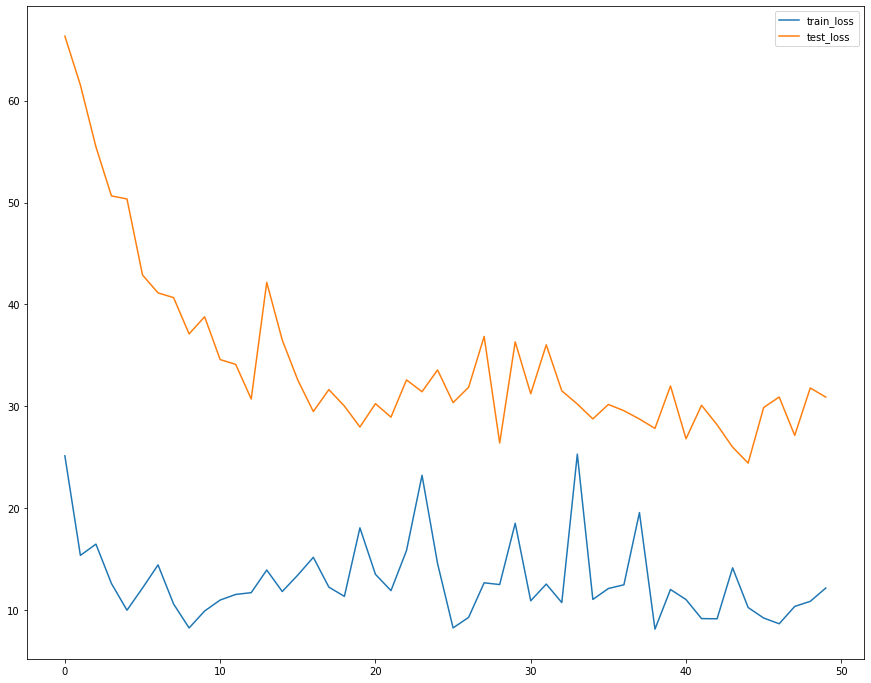

loss: 30.92


tensor(30.9163, device='cuda:0')

In [ ]:
# with no activation on embedding layer, target : S5
import torch.optim as optim
train_dataset, loader_train, val_dataset, loader_val, test_dataset, loader_test = get_datas(batch_size=128)
model = ELMObyDBMO(512,dropout=0.3)
optimizer = optim.SGD(model.parameters(),lr=0.006, momentum=0.9)
train_model(model,optimizer,epochs = 50)
check_error(loader_test, model)

test data: S7
########### epoch 0 ###########
Iteration 0, loss = 51.1188
Iteration 100, loss = 29.4351
Iteration 200, loss = 68.4740
Iteration 300, loss = 21.8437
Iteration 400, loss = 19.5007
loss: 30.66

########### epoch 1 ###########
Iteration 0, loss = 23.7018
Iteration 100, loss = 27.6467
Iteration 200, loss = 53.3363
Iteration 300, loss = 18.4043
Iteration 400, loss = 22.8462
loss: 26.72

########### epoch 2 ###########
Iteration 0, loss = 21.2344
Iteration 100, loss = 22.0792
Iteration 200, loss = 42.0755
Iteration 300, loss = 14.2412
Iteration 400, loss = 18.3332
loss: 25.22

########### epoch 3 ###########
Iteration 0, loss = 16.8231
Iteration 100, loss = 22.0035
Iteration 200, loss = 34.1650
Iteration 300, loss = 13.3740
Iteration 400, loss = 12.9454
loss: 19.82

########### epoch 4 ###########
Iteration 0, loss = 20.0115
Iteration 100, loss = 14.8698
Iteration 200, loss = 34.7496
Iteration 300, loss = 7.4955
Iteration 400, loss = 10.5693
loss: 17.41

########### epoch 5 ##

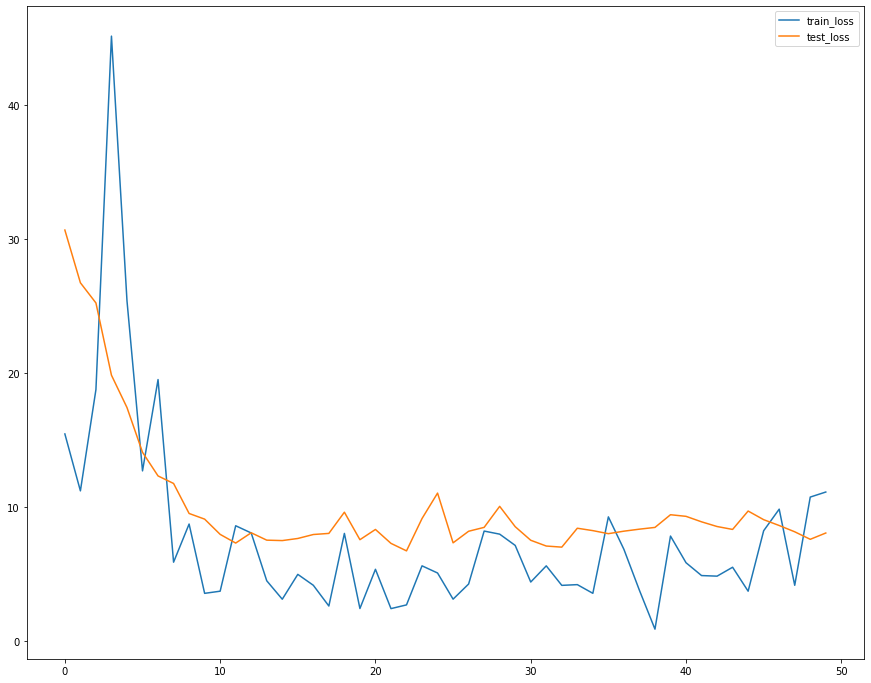

loss: 8.05


tensor(8.0464, device='cuda:0')

In [ ]:
# with no activation on embedding layer, target : S7
import torch.optim as optim
train_dataset, loader_train, val_dataset, loader_val, test_dataset, loader_test = get_datas(test_person_idx=6, batch_size=128)
model = ELMObyDBMO(512,dropout=0.3)
optimizer = optim.SGD(model.parameters(),lr=0.006, momentum=0.9)
train_model(model,optimizer,epochs = 50)
check_error(loader_test, model)

test data: S8
########### epoch 0 ###########
Iteration 0, loss = 51.1495
Iteration 100, loss = 31.5320
Iteration 200, loss = 43.0723
Iteration 300, loss = 65.9080
Iteration 400, loss = 39.9914
loss: 17.00

########### epoch 1 ###########
Iteration 0, loss = 23.5473
Iteration 100, loss = 29.7991
Iteration 200, loss = 35.9253
Iteration 300, loss = 54.4694
Iteration 400, loss = 30.6490
loss: 13.68

########### epoch 2 ###########
Iteration 0, loss = 21.8439
Iteration 100, loss = 22.7561
Iteration 200, loss = 33.8867
Iteration 300, loss = 42.7023
Iteration 400, loss = 27.1493
loss: 13.27

########### epoch 3 ###########
Iteration 0, loss = 18.9490
Iteration 100, loss = 17.3906
Iteration 200, loss = 20.7387
Iteration 300, loss = 39.1412
Iteration 400, loss = 24.4494
loss: 9.89

########### epoch 4 ###########
Iteration 0, loss = 21.1572
Iteration 100, loss = 13.7536
Iteration 200, loss = 20.4879
Iteration 300, loss = 36.4076
Iteration 400, loss = 20.1011
loss: 7.96

########### epoch 5 ###

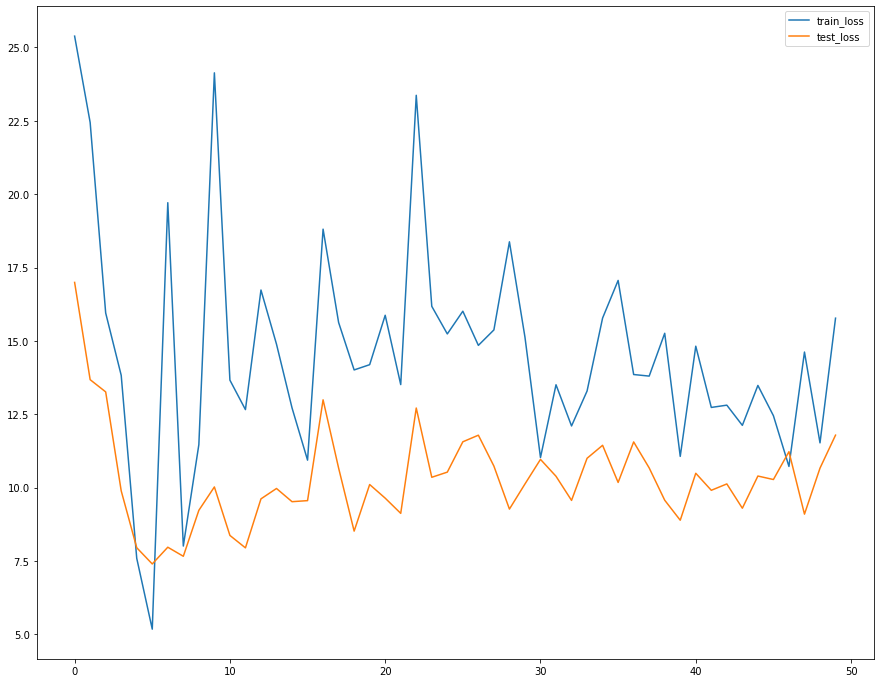

loss: 11.79


tensor(11.7911, device='cuda:0')

In [ ]:
# with no activation on embedding layer, target : S8
import torch.optim as optim
train_dataset, loader_train, val_dataset, loader_val, test_dataset, loader_test = get_datas(test_person_idx=7,batch_size=128)
model = ELMObyDBMO(512,dropout=0.3)
optimizer = optim.SGD(model.parameters(),lr=0.006, momentum=0.9)
train_model(model,optimizer,epochs = 10)
check_error(loader_test, model)

test data: S7
########### epoch 0 ###########
Iteration 0, loss = 51.3400
Iteration 100, loss = 56.6570
Iteration 200, loss = 71.5846
Iteration 300, loss = 19.9445
Iteration 400, loss = 21.8564
loss: 22.09

########### epoch 1 ###########
Iteration 0, loss = 23.7973
Iteration 100, loss = 27.1434
Iteration 200, loss = 40.9670
Iteration 300, loss = 26.2940
Iteration 400, loss = 26.9107
loss: 15.94

########### epoch 2 ###########
Iteration 0, loss = 32.2156
Iteration 100, loss = 21.0892
Iteration 200, loss = 32.0800
Iteration 300, loss = 28.0554
Iteration 400, loss = 21.5667
loss: 15.00

########### epoch 3 ###########
Iteration 0, loss = 32.4659
Iteration 100, loss = 19.0375
Iteration 200, loss = 34.8162
Iteration 300, loss = 28.3331
Iteration 400, loss = 20.5488
loss: 14.49

########### epoch 4 ###########
Iteration 0, loss = 27.5225
Iteration 100, loss = 17.7231
Iteration 200, loss = 34.1177
Iteration 300, loss = 27.7175
Iteration 400, loss = 17.5134
loss: 14.24

########### epoch 5 #

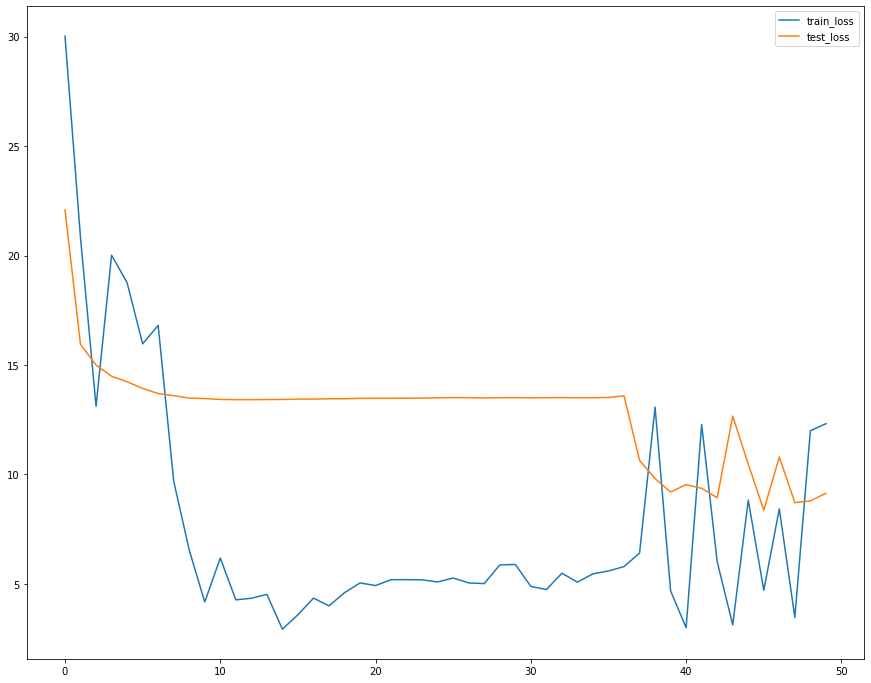

loss: 9.14


tensor(9.1442, device='cuda:0')

In [ ]:
# with Tanh embedding activation
import torch.optim as optim
train_dataset, loader_train, val_dataset, loader_val, test_dataset, loader_test = get_datas(test_person_idx=6, batch_size=128)
model = ELMObyDBMO(512,dropout=0.3)
optimizer = optim.SGD(model.parameters(),lr=0.006, momentum=0.9)
train_model(model,optimizer,epochs = 50)
check_error(loader_test, model)

test data: S7
########### epoch 0 ###########
Iteration 0, loss = 51.3732
Iteration 100, loss = 60.1796
Iteration 200, loss = 73.6338
Iteration 300, loss = 21.9274
Iteration 400, loss = 21.0800
loss: 22.79

########### epoch 1 ###########
Iteration 0, loss = 25.8710
Iteration 100, loss = 22.8400
Iteration 200, loss = 43.6706
Iteration 300, loss = 27.2239
Iteration 400, loss = 22.3181
loss: 15.75

########### epoch 2 ###########
Iteration 0, loss = 31.1119
Iteration 100, loss = 21.4425
Iteration 200, loss = 39.2378
Iteration 300, loss = 29.4766
Iteration 400, loss = 20.8715
loss: 14.83

########### epoch 3 ###########
Iteration 0, loss = 29.2887
Iteration 100, loss = 18.8009
Iteration 200, loss = 35.3116
Iteration 300, loss = 24.7236
Iteration 400, loss = 20.6190
loss: 14.53

########### epoch 4 ###########
Iteration 0, loss = 27.3959
Iteration 100, loss = 16.3727
Iteration 200, loss = 27.2619
Iteration 300, loss = 25.0789
Iteration 400, loss = 18.3644
loss: 14.13

########### epoch 5 #

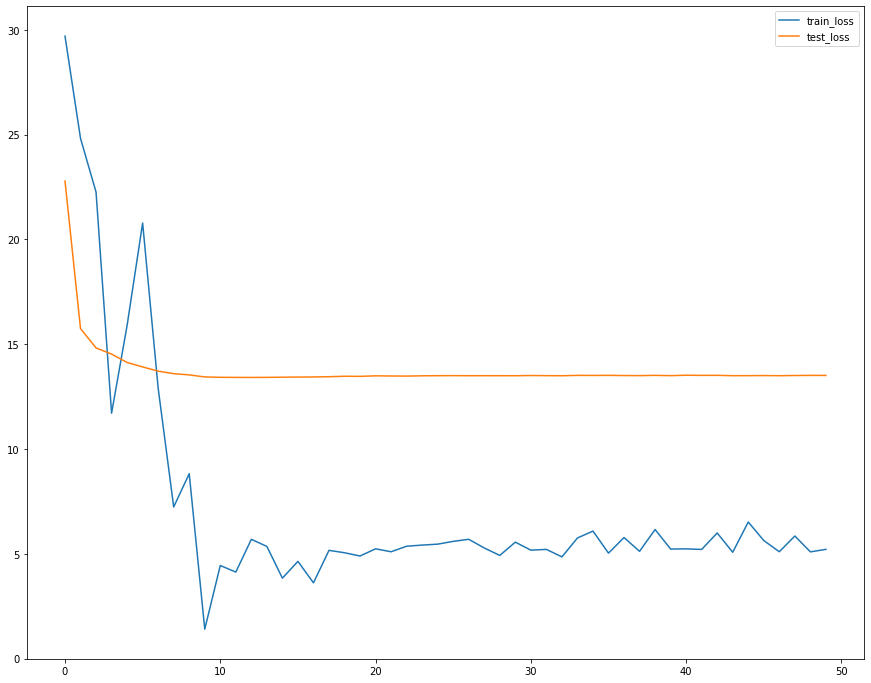

loss: 13.51


In [ ]:
# with sigmoid embedding activation
import torch.optim as optim
train_dataset, loader_train, val_dataset, loader_val, test_dataset, loader_test = get_datas(test_person_idx=6, batch_size=128)
model = ELMObyDBMO(512,dropout=0.3)
optimizer = optim.SGD(model.parameters(),lr=0.006, momentum=0.9)
train_model(model,optimizer,epochs = 50)
final_error = check_error(loader_test, model)